# Filtrado por capitalización de las criptomonedas.

Se comienza este proyecto filtrando los datos a través de la capitalización. Se consideró utilizar este filtro dado que la base de datos es muy extensa para recolectar todos los datos existentes.

La capitalización de mercado es un concepto financiero utilizado para medir el tamaño relativo de una criptomoneda, una empresa u otro activo financiero en el mercado. En el contexto de las criptomonedas, se refiere al valor total de todas las unidades de una criptomoneda en circulación multiplicado por su precio actual en el mercado.

En términos más simples, la capitalización de mercado representa la "valoración" total de una criptomoneda en función de su precio y cuántas unidades de esa criptomoneda existen en circulación.


Capitalización de Mercado = Precio Actual * Suma Total de Unidades en Circulación


Como el trabajo está hecho en colab, se instalan las librerías necesarias utilizando el símbolo "!" antes de importarlas.

In [1]:
!pip install pycoingecko

# Se realiza un filtro acorde a las 10 criptomonedas con mayor capitalización en los últimos 6 años

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI
import pandas as pd
import datetime
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler

Se comienza haciendo una petición a la API para filtrar las diez criptomonedas con mayor capitalización. Se aclara desde ahora y por única vez que, en todo lo que conlleva este análisis exploratorio, todos las unidades de todas las criptomonedas están medidos en términos de dólares.

In [3]:


# Definir la URL base de la API de CoinGecko
url = "https://api.coingecko.com/api/v3"

# Obtener la lista de criptomonedas ordenadas por capitalización de mercado
top_criptos = requests.get(f"{url}/coins/markets", params={"vs_currency": "usd", "order": "market_cap_desc"}).json()

# Tomar las primeras 10 criptomonedas (ajusta este valor según tu preferencia)
num = 10  # se pone 13 pero se seleccionan 10
seleccion = top_criptos[:num]

# Definir la fecha de inicio y fin para los datos históricos
hasta = datetime.now()
desde = hasta - timedelta(days=6 * 365)  # 6 años atrás

# Obtener los datos históricos para las criptomonedas seleccionadas en el lapso de 6 años
data_hist = []

for coin in seleccion:
    cripto_id = coin["id"]
    url_historical = f"{url}/coins/{cripto_id}/market_chart/range"
    params_historical = {
        "vs_currency": "usd",
        "from": int(desde.timestamp()),
        "to": int(hasta.timestamp())
    }

    response_historical = requests.get(url_historical, params=params_historical)
    hist = response_historical.json()

    if "prices" in hist:
        data_hist.append({"id": cripto_id, "prices": hist["prices"]})


Se crea un dataframe con los datos históricos

In [4]:
df_hist = pd.DataFrame()

# Se extrae el id de cada moneda
for data in data_hist:
    cripto_id = data["id"]

    # se obtiene la lista de precios de esa moneda
    prices = data["prices"]

    # se crea una lista con marcas temporales en días y precios
    timestamp_prices = []
    for valores in prices:
        timestamp = pd.to_datetime(valores[0], unit="ms")  # acá se indica como unidad los días
        price = valores[1]  # se toma el precio
        timestamp_prices.append((timestamp, price))  # se agrega la información a la lista

    # se crea una tabla con las marcas temporales y los precios de la moneda
    df_cripto = pd.DataFrame(timestamp_prices, columns=["timestamp", cripto_id])

    # Agregamos la tabla de la moneda al contenedor principal
    df_hist = pd.concat([df_hist, df_cripto], axis=1)

In [5]:
df_hist.head(2)

,timestamp,bitcoin,timestamp,ethereum,timestamp,tether,timestamp,binancecoin,timestamp,ripple,timestamp,usd-coin,timestamp,staked-ether,timestamp,dogecoin,timestamp,cardano
0,2017-08-17,4286.917435,2017-08-17,300.570344,2017-08-17,1.000000,2017-09-16,0.107251,2017-08-17,0.160787,2018-10-05,1.006242,2020-12-22,617.164997,2017-08-17,0.001730,2017-10-18,0.026845
1,2017-08-18,4097.685802,2017-08-18,296.114635,2017-08-18,0.990268,2017-09-17,0.154041,2017-08-18,0.158533,2018-10-06,1.001530,2020-12-23,617.164997,2017-08-18,0.001663,2017-10-19,0.026830


Dado que el cógido, por algún motivo muestra sólo 9 criptomonedas, se agregará una más, que es la que salió por primera vez, y figura en los raitings de varias fuentes: "solana"

se muestra el dataset con los precios de las 10 criptomonedas seleccionadas

In [6]:
cg = CoinGeckoAPI()

cripto = ['bitcoin', 'ethereum', 'tether', 'binancecoin', 'ripple', 'usd-coin', 'staked-ether', 'dogecoin', 'cardano', 'solana']
hasta = int(datetime.now().timestamp())
desde = int((datetime.now() - timedelta(days=6*365)).timestamp())

histo_data = [] # se guardará toda la información en esta lista y luego se pasará a dataframe

for criptomoneda in cripto:
    # se obtienen los datos del precio de la criptomoneda por medio de la api
    datos = cg.get_coin_market_chart_range_by_id(id=criptomoneda, vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

    # se crean listas para los precios y las marcas de tiempo
    precios = []
    marcas_tiempo = []

    for precio in datos["prices"]:
        # se agrega el precio a la lista "prices"
        precios.append(precio[1])

        # se agrega y convierte la marca de tiempo a la lista "marcas_tiempo"
        marca_tiempo = pd.to_datetime(precio[0], unit='ms')
        marcas_tiempo.append(marca_tiempo)

    # se crea un DataFrame con las marcas de tiempo y los precios de la criptomoneda
    df = pd.DataFrame({'timestamp': marcas_tiempo, criptomoneda: precios})

    # se establecen las marcas de tiempo como índice del DataFrame
    df.set_index('timestamp', inplace=True)

    # se agrega el DataFrame de la criptomoneda a la lista 'histo_data'
    histo_data.append(df)

dataframe = pd.concat(histo_data, axis=1)
#dataframe.to_csv('crypto_daily_data.csv')



In [7]:
dataframe.head(-3)

,bitcoin,ethereum,tether,binancecoin,ripple,usd-coin,staked-ether,dogecoin,cardano,solana
timestamp,,,,,,,,,,
2017-08-17,4286.917435,300.570344,1.000000,NaN,0.160787,NaN,NaN,0.001730,NaN,NaN
2017-08-18,4097.685802,296.114635,0.990268,NaN,0.158533,NaN,NaN,0.001663,NaN,NaN
2017-08-19,4115.211988,296.622090,1.020000,NaN,0.155775,NaN,NaN,0.001642,NaN,NaN
2017-08-20,4001.228632,295.171577,0.996677,NaN,0.159505,NaN,NaN,0.001674,NaN,NaN
2017-08-21,3935.229933,322.201220,1.000000,NaN,0.193611,NaN,NaN,0.001687,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-08,29178.147752,1826.933486,0.998873,241.738425,0.620838,1.000073,1821.723824,0.073374,0.290181,23.052000
2023-08-09,29779.561671,1856.844145,0.999945,245.179427,0.642624,1.000085,1856.795133,0.075010,0.297832,24.203817
2023-08-10,29585.488077,1855.890727,0.999712,244.010315,0.643605,1.000002,1855.359403,0.075385,0.301206,24.384610


Se eliminan duplicados

In [8]:
dataframe.drop_duplicates()

,bitcoin,ethereum,tether,binancecoin,ripple,usd-coin,staked-ether,dogecoin,cardano,solana
timestamp,,,,,,,,,,
2017-08-17,4286.917435,300.570344,1.000000,NaN,0.160787,NaN,NaN,0.001730,NaN,NaN
2017-08-18,4097.685802,296.114635,0.990268,NaN,0.158533,NaN,NaN,0.001663,NaN,NaN
2017-08-19,4115.211988,296.622090,1.020000,NaN,0.155775,NaN,NaN,0.001642,NaN,NaN
2017-08-20,4001.228632,295.171577,0.996677,NaN,0.159505,NaN,NaN,0.001674,NaN,NaN
2017-08-21,3935.229933,322.201220,1.000000,NaN,0.193611,NaN,NaN,0.001687,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-11,29423.818916,1850.876989,0.998899,241.231912,0.633214,0.999861,1849.451423,0.075759,0.296027,24.618873
2023-08-12,29396.847971,1847.541835,0.998938,239.595822,0.631618,1.000269,1846.298313,0.075714,0.293325,24.579810
2023-08-13,29412.142275,1848.505239,0.999377,240.088445,0.627081,0.999880,1846.710998,0.076696,0.291666,24.891819


In [9]:
dataframe.shape

(2202, 10)

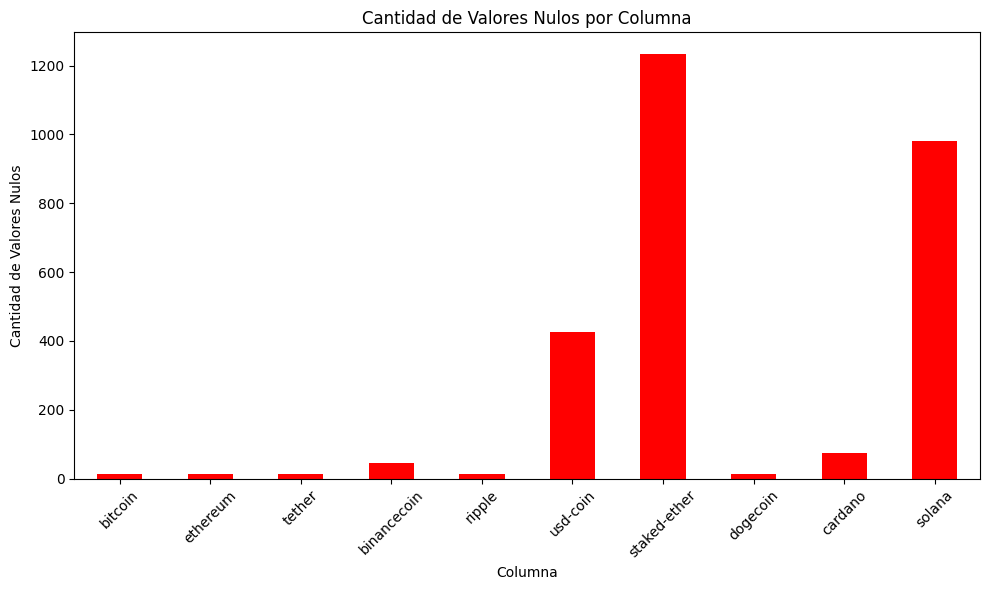

In [10]:
# Calcular la cantidad de valores nulos por columna
conteo_nulos = dataframe.isnull().sum()

# Crear el gráfico de barras con barras rojas para valores nulos
plt.figure(figsize=(10, 6))
conteo_nulos.plot(kind='bar', color=['red' if count > 0 else 'blue' for count in conteo_nulos])
plt.title('Cantidad de Valores Nulos por Columna')
plt.xlabel('Columna')
plt.ylabel('Cantidad de Valores Nulos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Como se observa, 'staked-ether', 'solana', y 'usd-coin' presentan nulos, una posibilidad es que dichas criptomonedas sean relativamente nuevas, en tal caso dichos nulos podrían ser, en mayoría, correspondientes a un período temporal donde no existían. Se Corroborará eso.

Staked-ether

In [11]:
# se encuentra la posible fecha del primer valor nulo en el índice "timestamp"
fecha_primer_nulo = dataframe.index[dataframe["staked-ether"].isnull()].max()

# se filtra el DataFrame a partir de la fecha del primer valor nulo
datos_desde_primer_nulo_staked_ether = dataframe.loc[fecha_primer_nulo:]

In [12]:
datos_desde_primer_nulo_staked_ether.head()

,bitcoin,ethereum,tether,binancecoin,ripple,usd-coin,staked-ether,dogecoin,cardano,solana
timestamp,,,,,,,,,,
2020-12-21,23518.318421,639.515437,1.002810,34.189929,0.560066,0.999370,NaN,0.004616,0.162049,1.563348
2020-12-22,22840.991707,610.427028,1.002030,32.303140,0.517176,0.996955,617.164997,0.004802,0.153691,1.543421
2020-12-23,23794.793303,634.979723,1.001962,33.509891,0.451321,1.002172,617.164997,0.004534,0.157080,1.492884
2020-12-24,23308.127232,587.958895,1.004013,31.298017,0.260507,1.002596,596.767711,0.003826,0.138430,1.206243
2020-12-25,23760.287049,612.879657,1.002383,32.496951,0.344804,1.002147,611.504712,0.004587,0.152868,1.363459


Se observa que, a partir de diciembre del 2020 staked-ether comenzó a aparecer en la base de datos

Solana

In [13]:
# se encuentra la fecha del primer valor nulo en el índice "timestamp"
fecha_primer_nulo_solana = dataframe.index[dataframe["solana"].isnull()].max()

# se filtra el DataFrame a partir de la fecha del primer valor nulo
datos_desde_primer_nulo_solana = dataframe.loc[fecha_primer_nulo_solana:]

In [14]:
datos_desde_primer_nulo_solana.head()

,bitcoin,ethereum,tether,binancecoin,ripple,usd-coin,staked-ether,dogecoin,cardano,solana
timestamp,,,,,,,,,,
2020-04-10,7294.488875,170.095104,1.000048,15.028759,0.198069,0.998592,NaN,0.002024,0.036239,NaN
2020-04-11,6864.694257,157.740158,1.001752,13.718826,0.188429,0.999907,NaN,0.001955,0.033551,0.957606
2020-04-12,6878.781213,158.327878,1.001414,13.826759,0.188586,1.000246,NaN,0.001995,0.033338,0.784711
2020-04-13,6913.158787,158.863826,0.996086,14.265117,0.187934,0.997223,NaN,0.001976,0.033503,0.875994
2020-04-14,6857.538538,156.701359,0.998972,15.045573,0.188272,0.999008,NaN,0.001960,0.033165,0.786712


Se observa también, que solana aparece en la base de datos desde abril de 2020

Usd-coin

In [15]:
# se encuentra la fecha del primer valor nulo en el índice "timestamp"
fecha_primer_nulo_usd_coin = dataframe.index[dataframe["usd-coin"].isnull()].max()

# se filtra el DataFrame a partir de la fecha del primer valor nulo
datos_desde_primer_nulo_usd_coin = dataframe.loc[fecha_primer_nulo_usd_coin:]

In [16]:
datos_desde_primer_nulo_usd_coin.head()

,bitcoin,ethereum,tether,binancecoin,ripple,usd-coin,staked-ether,dogecoin,cardano,solana
timestamp,,,,,,,,,,
2018-10-04,6499.262379,220.474460,0.999414,10.283051,0.528512,NaN,NaN,0.005738,0.080886,NaN
2018-10-05,6578.701809,222.195848,1.000008,10.306821,0.527542,1.006242,NaN,0.005657,0.081458,NaN
2018-10-06,6621.189364,228.036070,0.998736,10.653451,0.519753,1.001530,NaN,0.005686,0.083198,NaN
2018-10-07,6589.124682,225.068807,1.000266,10.427394,0.488679,1.001177,NaN,0.005592,0.081495,NaN
2018-10-08,6584.832153,225.658349,0.999782,10.549877,0.483068,1.001906,NaN,0.005604,0.084611,NaN


Se concluye que, no se eliminarán filas del dataset por nulos, sino que se reemplazarán dichos nulos por "0".

In [17]:
dataframe.fillna(0,inplace=True)

# Correlación entre el precio de las criptomonedas

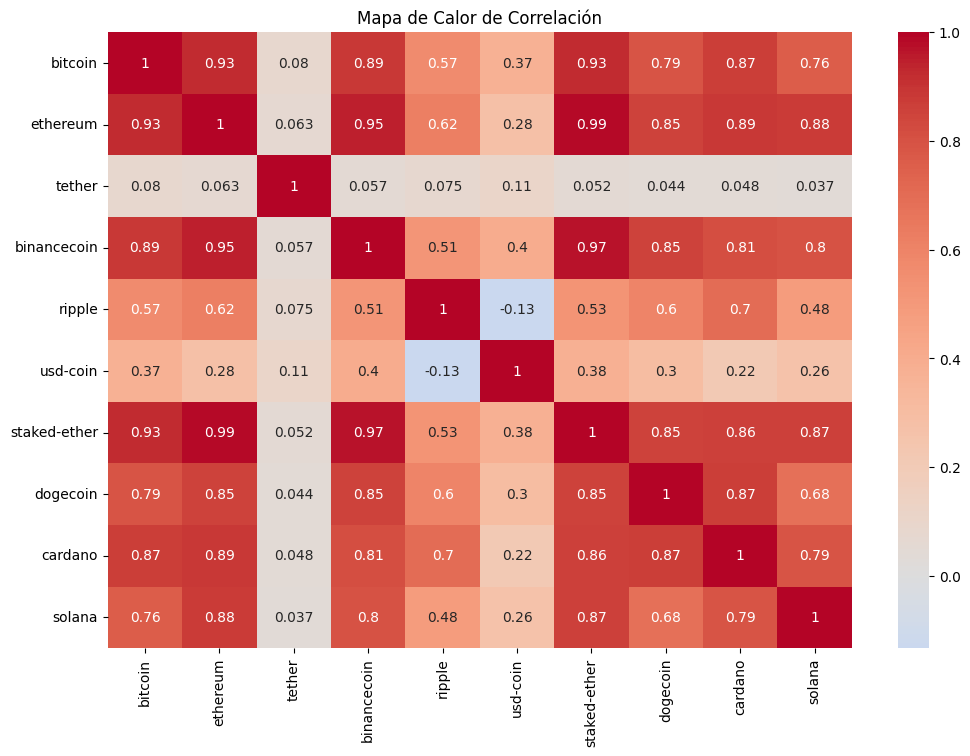

In [18]:
# se crea una la matriz de correlación
correlation_matrix = dataframe.corr()

# Crear un mapa de calor de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Mapa de Calor de Correlación')
plt.show()

El mapa de calor presenta una fuerte correlación entre varias criptomonedas respecto a su precio. Por ejemplo, se puede decir que en estos últimos 6 años, si el precio de ethereum aumentó, también lo hizo binancecoin ( se aclara que esto no implica una relación de causalidad ) . Esto podría servir, por ejemplo, para sugerir no invertir en ambas criptomonedas si un cliente deseara tener una cartera diversificada. La visualización de altas correlaciones puede deberse a muchos factores que podrían aclararse mejor desde un enfoque del análisis fundamental. Sin embargo, esto no implica necesariamente que todas las criptomonedas tengas las mismas señales de compra o de venta, como se verá en el análisis del dashboard.

# Gráficos de caja

A continuación se presentarán algunos gráficos de cajas con la intención de detectar, en primera instancia de forma visual la distribución de los datos de precio

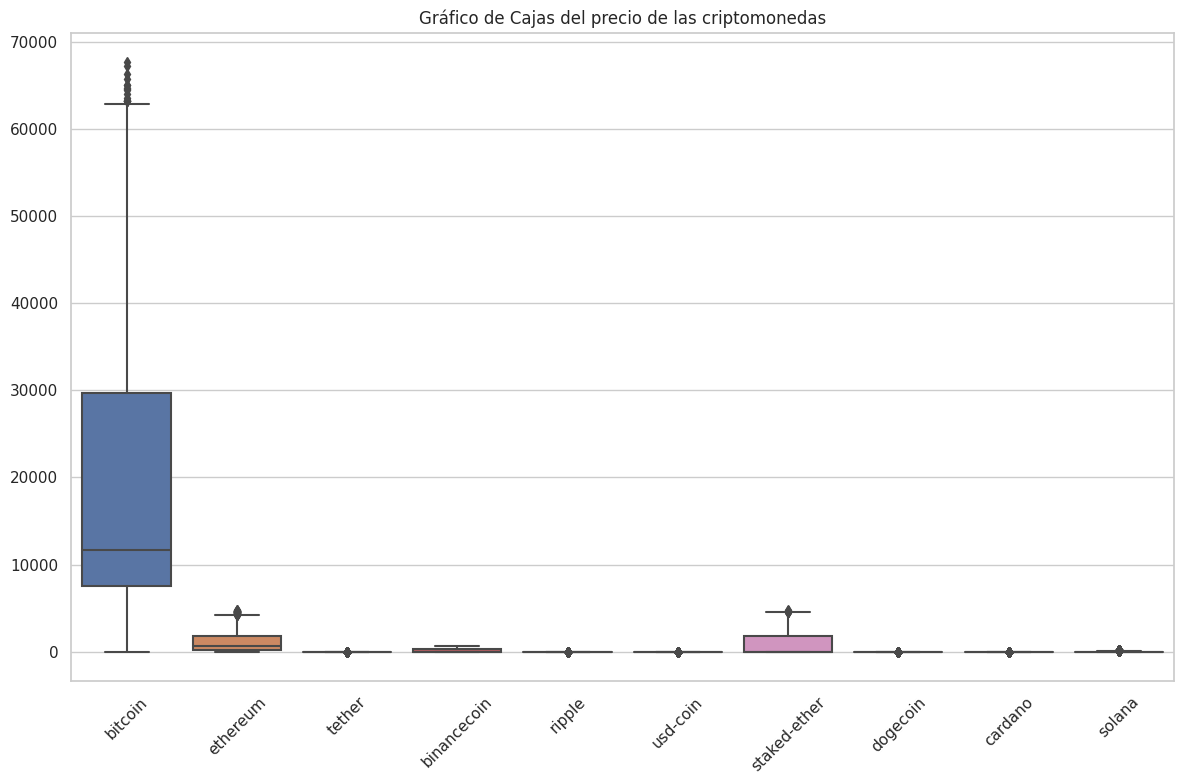

In [19]:
# Configurar el estilo estético de Seaborn
sns.set(style="whitegrid")

# Crear un gráfico de cajas para las columnas en combined_data
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataframe)
plt.title("Gráfico de Cajas del precio de las criptomonedas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


las escalas del gráfico son muy diferentes, se realizará una estandarización de los datos, para poder obtener una mejor visualización de los mismos. Es importante dejar en claro que dicha escala será a través de la función z-score. ( en términos técnicos se habla de "función" porque se podría definir matemáticamente a la técnica de z-score como una función que se aplica a cada variable )

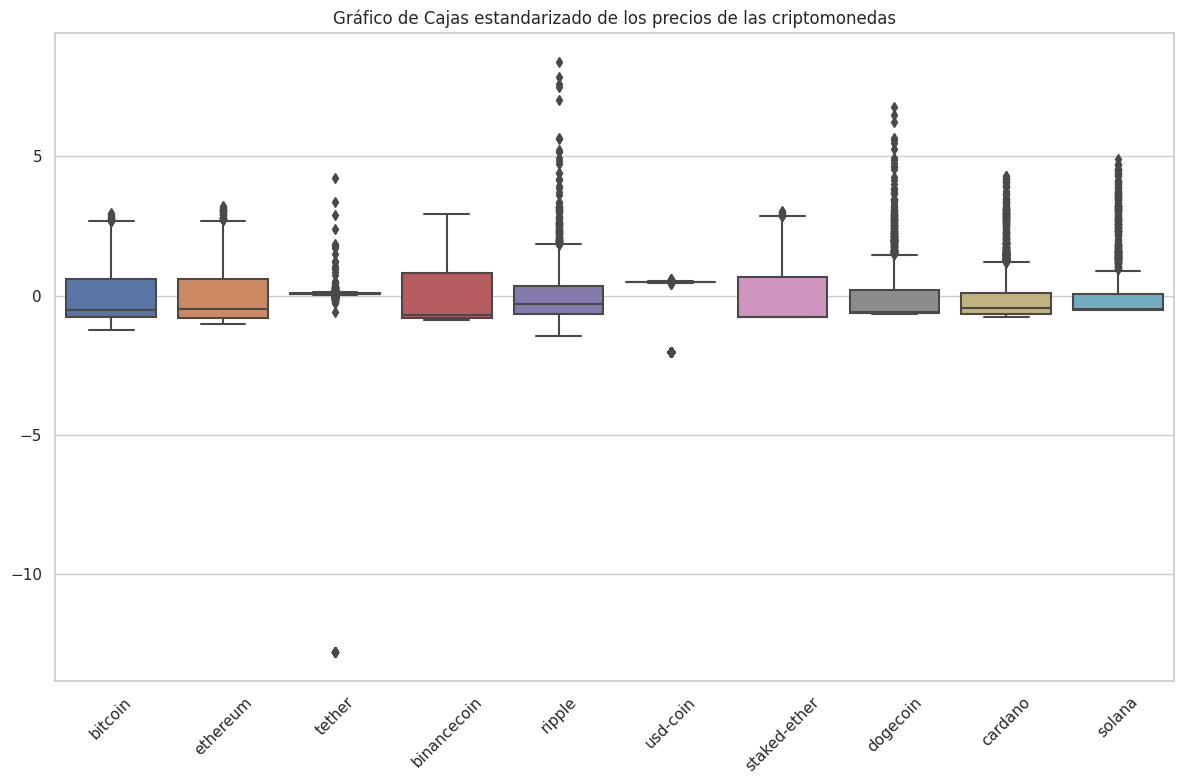

In [20]:
# se estandarizan los datos
scaler = StandardScaler()
dataframe_st = scaler.fit_transform(dataframe)

# se crea un DataFrame con los datos estandarizados y los nombres de columnas originales
df_dataframe_std = pd.DataFrame(dataframe_st, columns=dataframe.columns)

# se configura el estilo estético de Seaborn
sns.set(style="whitegrid")

# se crea un gráfico de cajas para las columnas en df_combined_data_standardized
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_dataframe_std)
plt.title("Gráfico de Cajas estandarizado de los precios de las criptomonedas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- En este gráfico se puede visualizar un poco mejor la distribución de los datos. En el contexto de este gráfico, esto significa que hubo algunos cambios abruptos del precio ( esto se puede afirmar sólo para los puntos aislados ). Otros cambios probablemente fueron un poco más progresivos. Los outliers negativos aislados  muestran que hubo una disminución abrupta del precio para los puntos aislados, y de forma inversa, los outliers positivos aislados explican que hubo un aumento del precio significativo y brusco.
- Los cambios más bruscos se observan en las bajadas de precios de las criptomonedas tether y usd coin. Esto no descarta que las variaciones de las otras criptomonedas no lo sean y no pueda esto representar un riesgo.
- Los boxplots con bigotes más largos indican que dichas criptomonedas son de mayor volatilidad en general. Es importante destacar que estos boxplots mencionados, presentan unos bigotes con mayor longitud hacia arriba, es decir, hay más valores con mayor precio por encima del rango intercuartil que por debajo, esto se traduce en que dichas criptomonedas presentan una tendencia a cambios más bruscos de subida que de bajada del precio. Las stablecoins ( "tether" y "usd-coin" ) presentan una caja casi idéntica al valor la media, lo cual muestra que, en términos generales, son más estables, como se esperaría.  

 - Respecto a los utliers, estos se dejarán, puesto que se intentará comprender qué patrones se podrían encontrar en los períodos de alta volatilidad y esto podría ayudar a los inversores a tomar decisiones más precabidas.

# Representación con medias móviles

A continuación se muestra un gráfico de los precios de las criptomonedas con su representación de medias móviles. Es necesario aclarar para una mejor comprensión del análisis precedente que, cuando una media móvil se cruza con el precio original esto "podría" significar un cambio de tendencia. Esto tiene sentido dado que, por ejemplo, si el precio venía bajando, su media móvil que siempre vendrá defasada indicará tendencia bajista, y si de repente el precio sube y atraviesa esta media móvil, la brusquedad de ese cambio podría ser una señal de alerta de que hay un cambio a una tendencia alcista. Se consideró la media móvil de período 120 días, dado que las tendencias son más claras y de tomar valores más bajos, se tendría más sensibilidad a los cambios, no es lo que se busca para este análisis.

Otra aclaración importante es que, no se intenta profundizar en los análisis de los siguientes gráficos, la ide es simplemente tener un panorama general de lo que está sucdiendo con el precio de cada criptomoneda. Un análisis un poco más detallado se hará en la presentación del dashboard.

In [21]:
criptos = ['bitcoin', 'ethereum', 'tether', 'binancecoin', 'ripple','usd-coin','staked-ether','dogecoin','cardano','solana']

# Bitcoin

<ipython-input-22-39ee893bd0ff>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


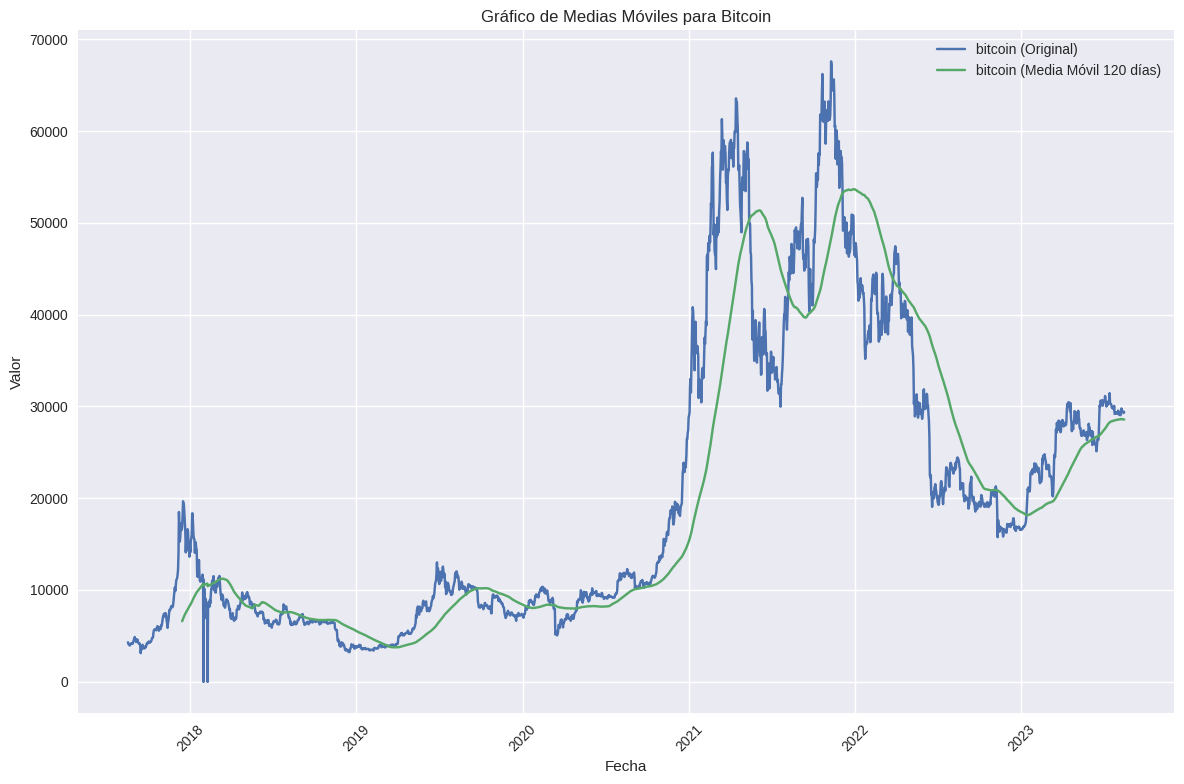

In [22]:
# se calcula la media móvil con una ventana de 120 días para la columna "bitcoin"
window = 120
dataframe['bitcoin_media_movil'] = dataframe['bitcoin'].rolling(window=window).mean()

# se configura el estilo estético de Matplotlib
plt.style.use('seaborn')

# se crea el gráfico de la columna "bitcoin" y su media móvil
plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['bitcoin'], label='bitcoin (Original)')
plt.plot(dataframe.index, dataframe['bitcoin_media_movil'], label=f'bitcoin (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



Actualmente, el precio está por encima de la media móvil, lo que indica que aún podría continuar la tendencia levemente alcista del precio.

# Tether

Dado que tether es una stablecoin no se visualizará el gráfico, pese a que en el boxplot se pudo observar cambios bruscos en el precio.

# Binancecoin

<ipython-input-23-93b7a9f83509>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


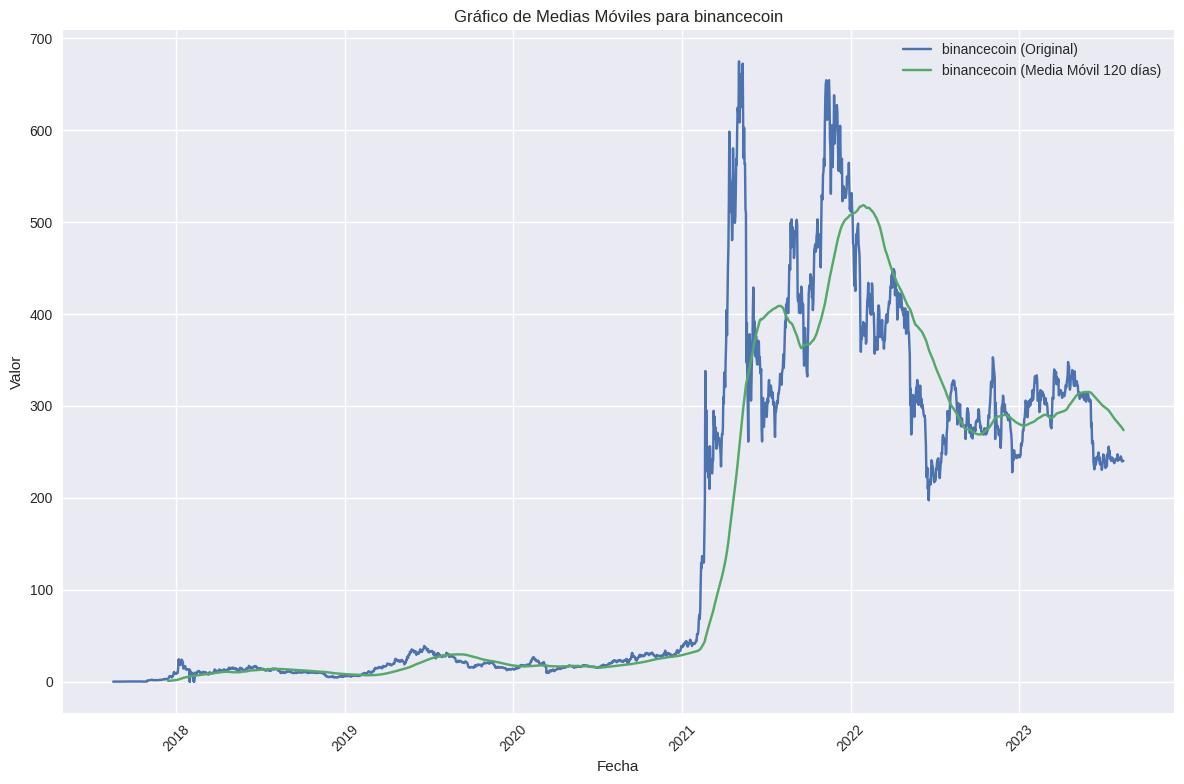

In [23]:

window = 120
dataframe['binancecoin_media_movil'] = dataframe['binancecoin'].rolling(window=window).mean()

plt.style.use('seaborn')

plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['binancecoin'], label='binancecoin (Original)')
plt.plot(dataframe.index, dataframe['binancecoin_media_movil'], label=f'binancecoin (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para binancecoin')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

El precio de binancecoin se mantiene poco variable, sería prudente esperar y ver si se junta un poco más la media móvil con el precio, lo que podría indicar una señal de cambio a tendencia alcista.

# Ripple

<ipython-input-24-c1f76ad3ca42>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


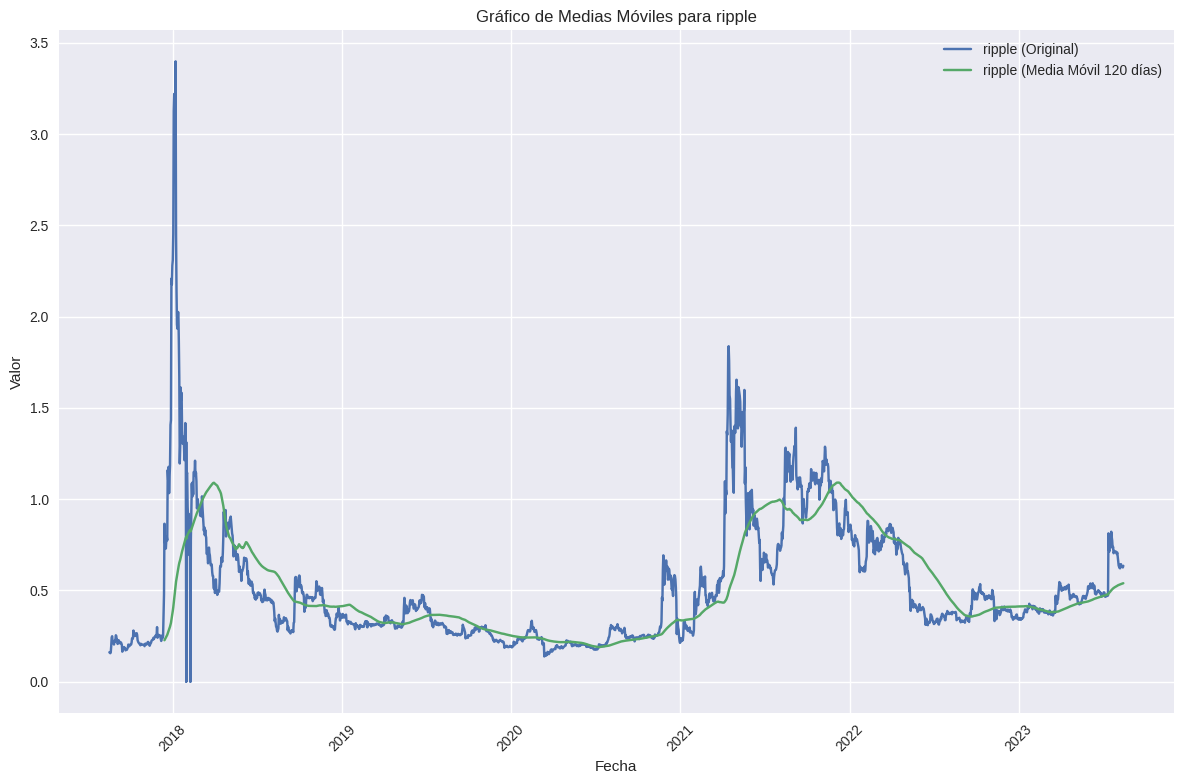

In [24]:

window = 120
dataframe['ripple_media_movil'] = dataframe['ripple'].rolling(window=window).mean()


plt.style.use('seaborn')

plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['ripple'], label='ripple (Original)')
plt.plot(dataframe.index, dataframe['ripple_media_movil'], label=f'ripple (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para ripple')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Se observa cómo en estos últimos meses el precio viene pisando la media móvil, pero no la atraviesa.

# Staked-ether

<ipython-input-25-534bf707781b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


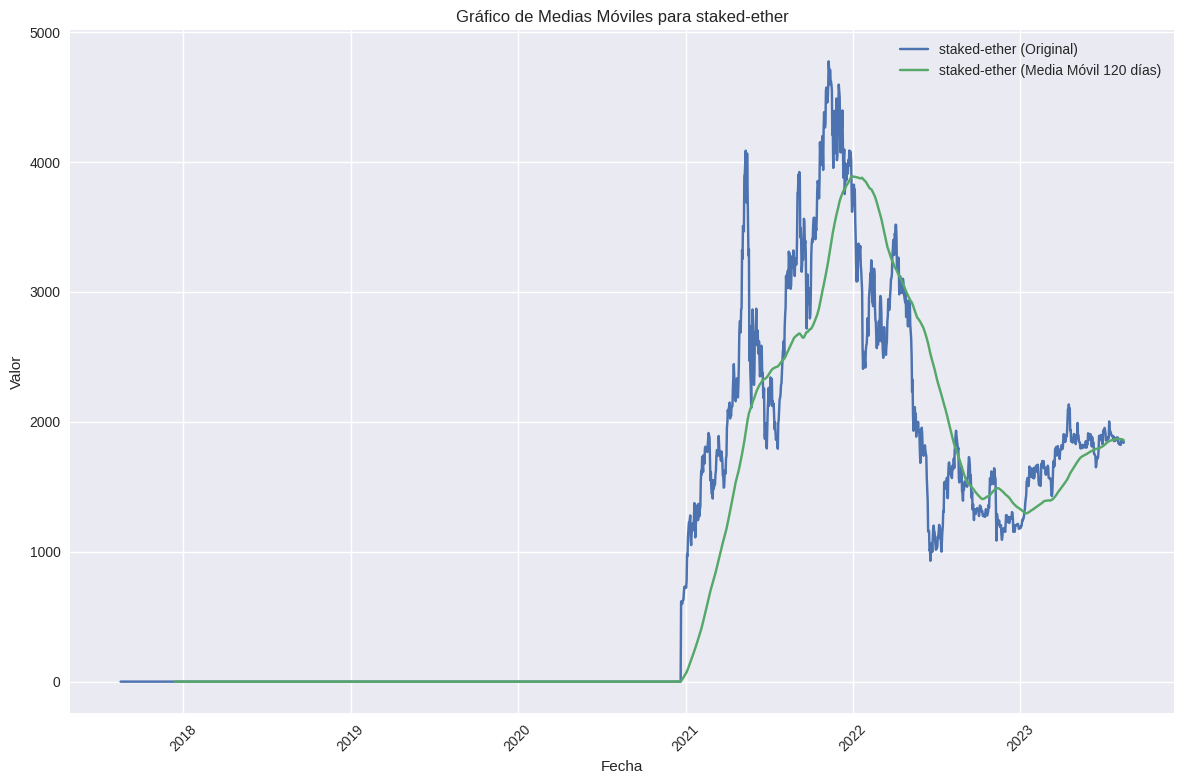

In [25]:

window = 120
dataframe['staked-ether_media_movil'] = dataframe['staked-ether'].rolling(window=window).mean()

# Configurar el estilo estético de Matplotlib
plt.style.use('seaborn')

# Crear el gráfico de la columna "staked-ether" y su media móvil
plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['staked-ether'], label='staked-ether (Original)')
plt.plot(dataframe.index, dataframe['staked-ether_media_movil'], label=f'staked-ether (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para staked-ether')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

El precio en estos últimos meses está variando de forma conjunta con la media móvil, eso evidencia la poca fluctuación del precio, sería interesante comparar esto con un gráfico de volúmen para corroborar si hay muchas o pocas compras de esta criptomoneda, si hubieran muchas, esto podría ser un indicador más a favor de una posible compra.

# Dogecoin

<ipython-input-26-65f2674f1393>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


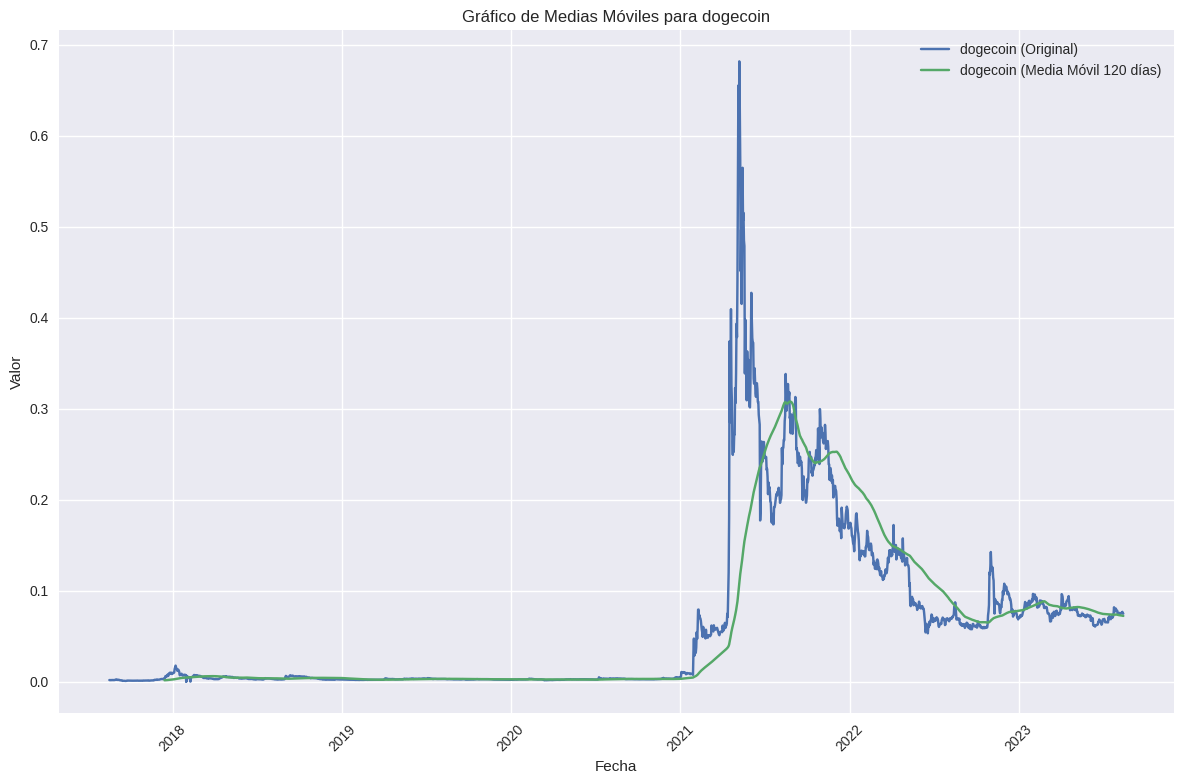

In [26]:
window = 120
dataframe['dogecoin_media_movil'] = dataframe['dogecoin'].rolling(window=window).mean()


plt.style.use('seaborn')


plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['dogecoin'], label='dogecoin (Original)')
plt.plot(dataframe.index, dataframe['dogecoin_media_movil'], label=f'dogecoin (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para dogecoin')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Se observa que desde fines del año 2022 hasta ahora no hay una señal clara de la tendencia del precio.

# Solana

<ipython-input-27-1bc95a5c1d70>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


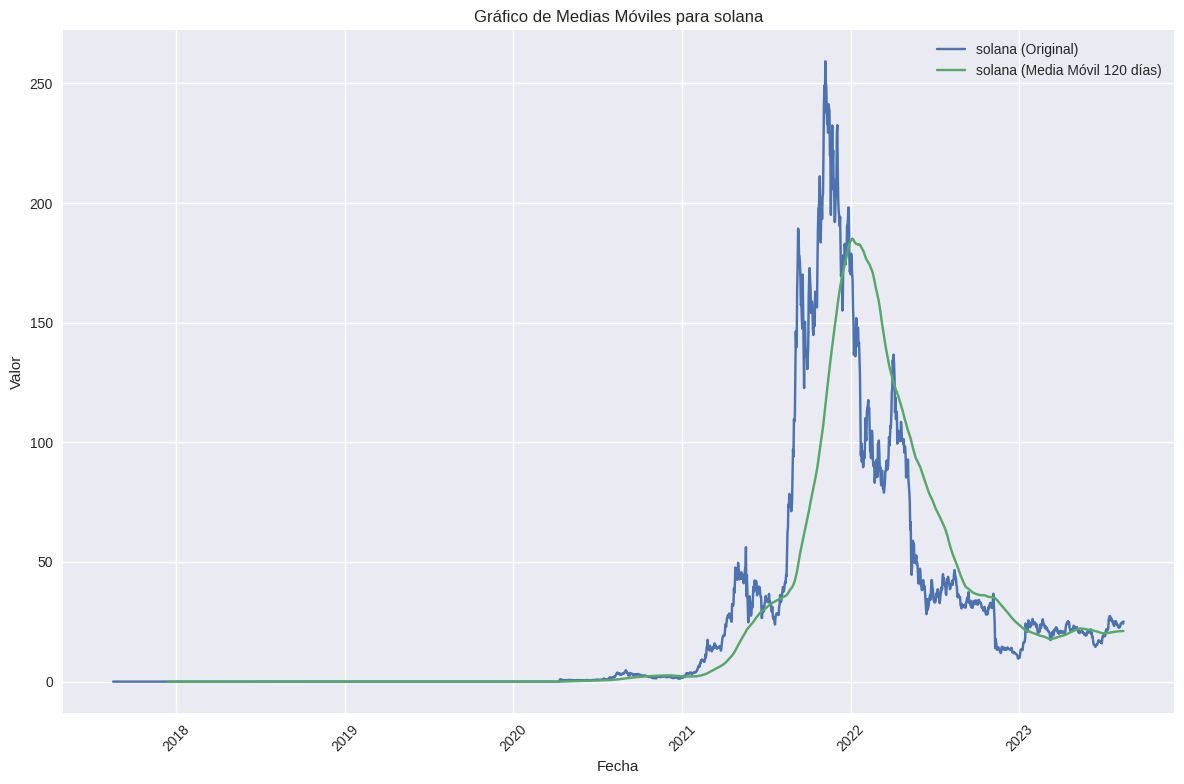

In [27]:
window = 120
dataframe['solana_media_movil'] = dataframe['solana'].rolling(window=window).mean()

plt.style.use('seaborn')

plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['solana'], label='solana (Original)')
plt.plot(dataframe.index, dataframe['solana_media_movil'], label=f'solana (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para solana')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

bservando el último cruce de la media móvil se observa que el precio está por encima de ésta, pero no fluctúa mucho, esto indica que de momento el precio se mantiene estable.

# Cardano

<ipython-input-28-ebab54a80595>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


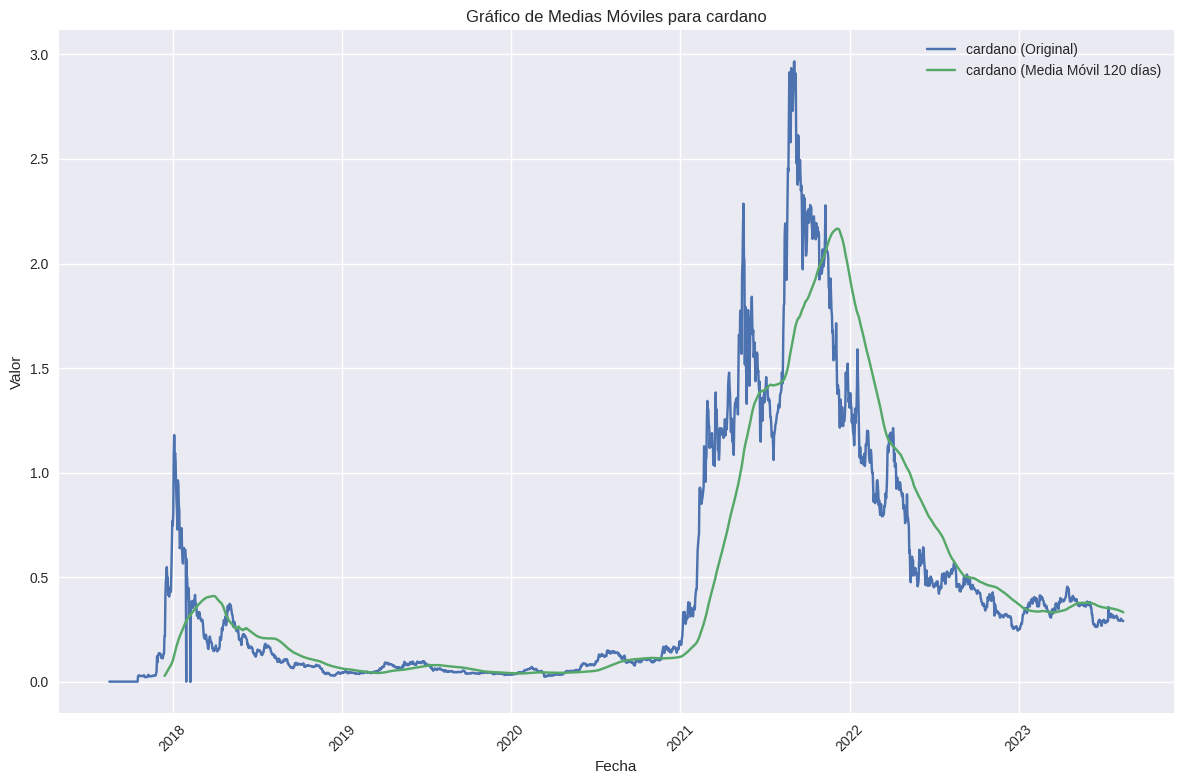

In [28]:
window = 120
dataframe['cardano_media_movil'] = dataframe['cardano'].rolling(window=window).mean()

plt.style.use('seaborn')

plt.figure(figsize=(12, 8))
plt.plot(dataframe.index, dataframe['cardano'], label='cardano (Original)')
plt.plot(dataframe.index, dataframe['cardano_media_movil'], label=f'cardano (Media Móvil {window} días)')

plt.title('Gráfico de Medias Móviles para cardano')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

El último cruce de la media móvil con el precioindica una tendencia bajista que aún continúa.

# Volumen

Otro aspecto a analizar, además del precio o capitalización, es el volúmen. A continuación se visualizará el volúmen de cada criptomoneda correspondiente al mismo lapso temporal de 6 años. Se aclara que esto es simplemente para conocer un poco más el dataset, dado que, en power bi se volverá a hacer un análisis de volúmen para mostrar algunas kpis. Una vez presentados los gráficos de volúmen de cada criptomoneda, se compararán todas en un mismo gráfico.

Aclaración: Respecto a las escalas de los gráficos que se presentarán a continuación, aparecen los símbolos:   "1eX" done "X" irá variando acorde a la magnitud del volúmen de cada gráfico. Por ejemplo, si se tiene 1e11, esto significa "1 * 10 elevado a la 11". Si en el gráfico se marca por ejemplo 0.4, esto quiere decir que el volúmen, con la escala 1e11 es de 0.4 * 1  * 10 ^11 = 40.000.000.000. Esto se aclara para una mejor comprensión del gráfico.

# Tether

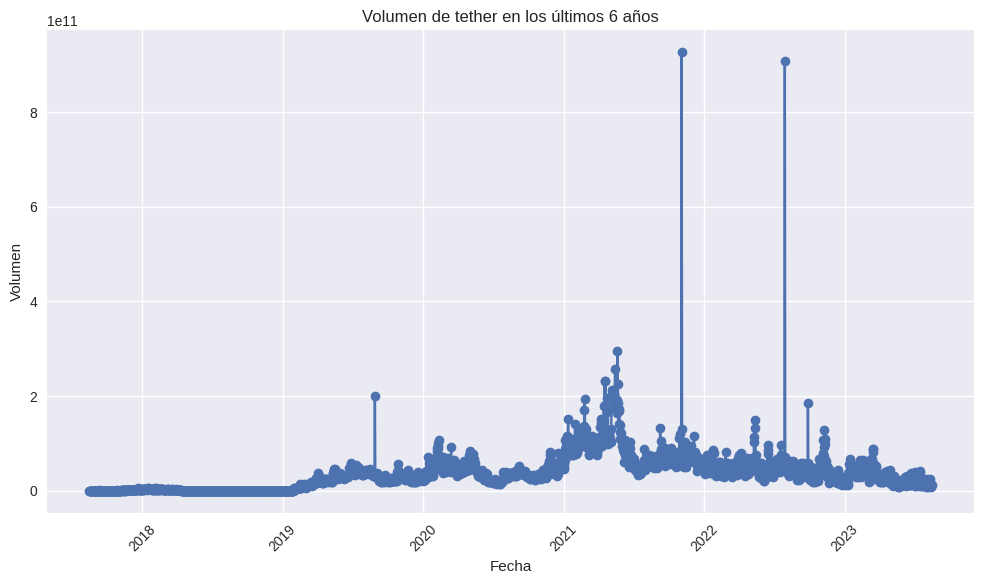

In [29]:
# se extraen los volúmenes y las fechas para Tether
tether_data = cg.get_coin_market_chart_range_by_id(id='tether', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in tether_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in tether_data['prices']]

# se crea un DataFrame con los datos para luego poder visualizarlo
df_tether = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

# Se crea un gráfico de volúmen para tether

plt.figure(figsize=(10, 6))
plt.plot(df_tether['timestamp'], df_tether['volume'], marker='o')
plt.title('Volumen de tether en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Se puede apreciar que, el volúmen de tether se mantiene relativamente uniforme, salvo por unos picos a fines de año 2022 y mediados de 2022

# Binancecoin

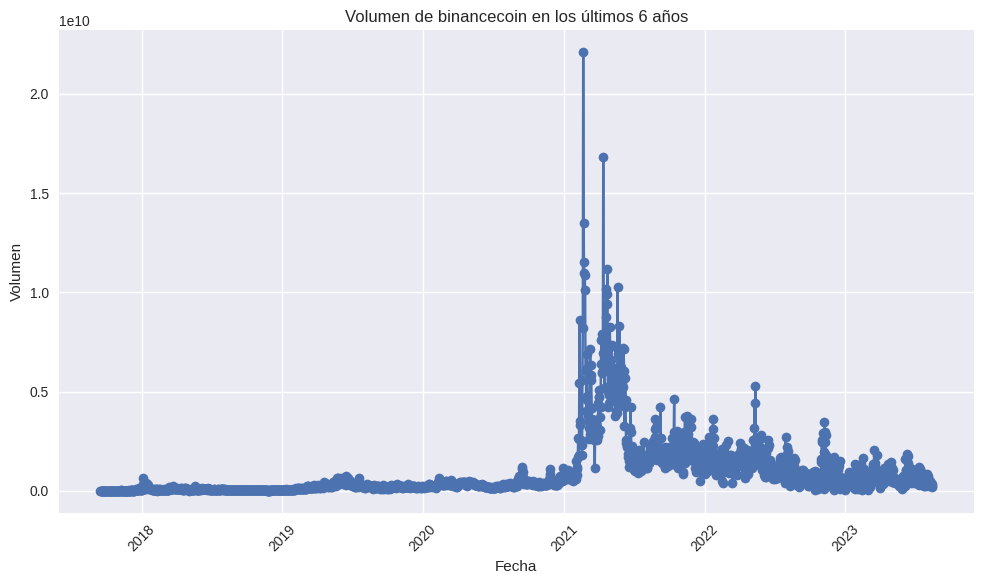

In [30]:
binancecoin_data = cg.get_coin_market_chart_range_by_id(id='binancecoin', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)


volumes = [entry[1] for entry in binancecoin_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in binancecoin_data['prices']]


df_binancecoin = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})


plt.figure(figsize=(10, 6))
plt.plot(df_binancecoin['timestamp'], df_binancecoin['volume'], marker='o')
plt.title('Volumen de binancecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En este gráfico se aprecia que la variación del volumen es similar a la de ethereum. Los mayores picos se encuentran desde principios del año 2021 y mediados de dicho año.

# ripple

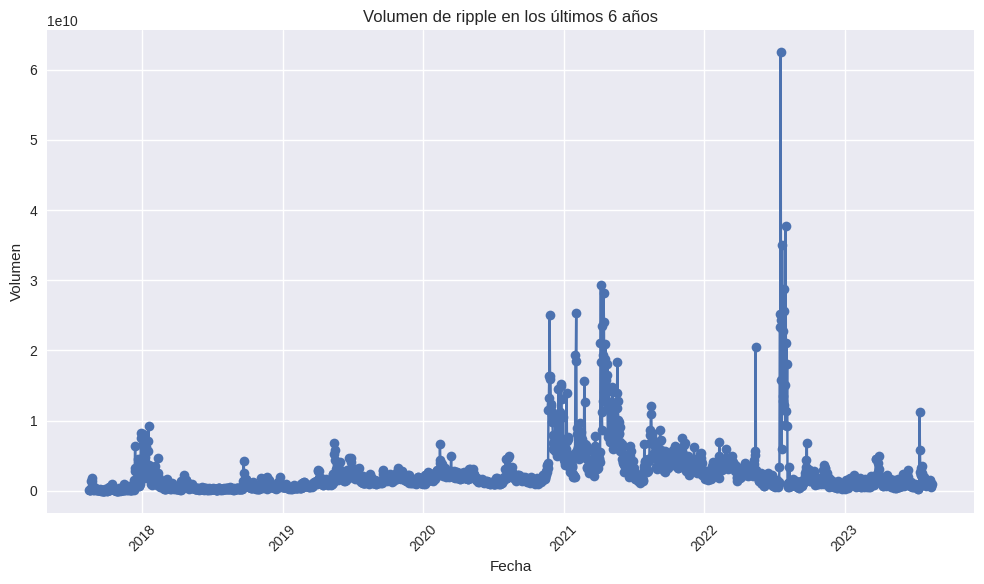

In [31]:
ripple_data = cg.get_coin_market_chart_range_by_id(id='ripple', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in ripple_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in ripple_data['prices']]


df_ripple = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})


plt.figure(figsize=(10, 6))
plt.plot(df_ripple['timestamp'], df_ripple['volume'], marker='o')
plt.title('Volumen de ripple en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# usd-coin

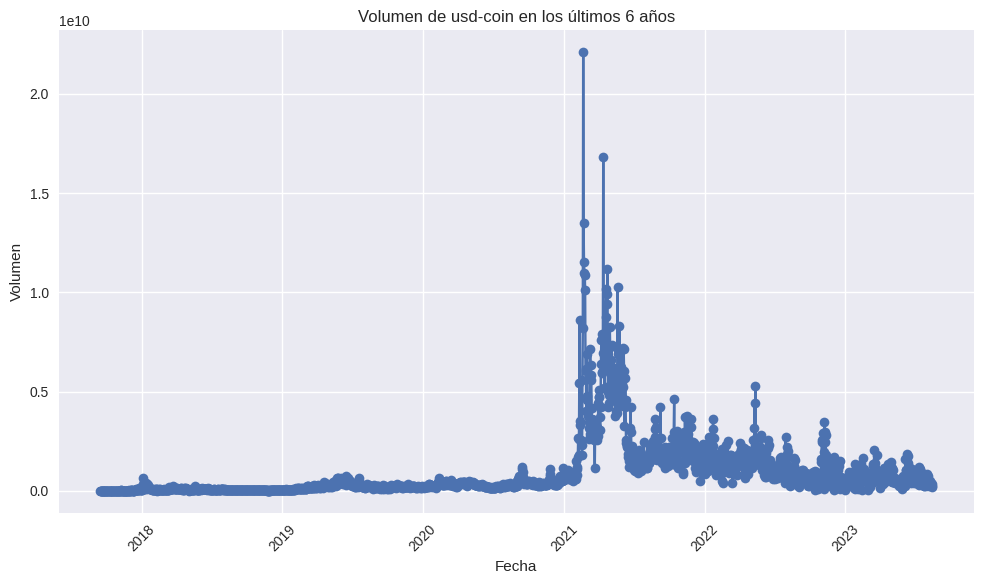

In [32]:
usd_coin_data = cg.get_coin_market_chart_range_by_id(id='usd-coin', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in usd_coin_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in usd_coin_data['prices']]

df_usd_coin = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_binancecoin['timestamp'], df_binancecoin['volume'], marker='o')
plt.title('Volumen de usd-coin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# staked-ether

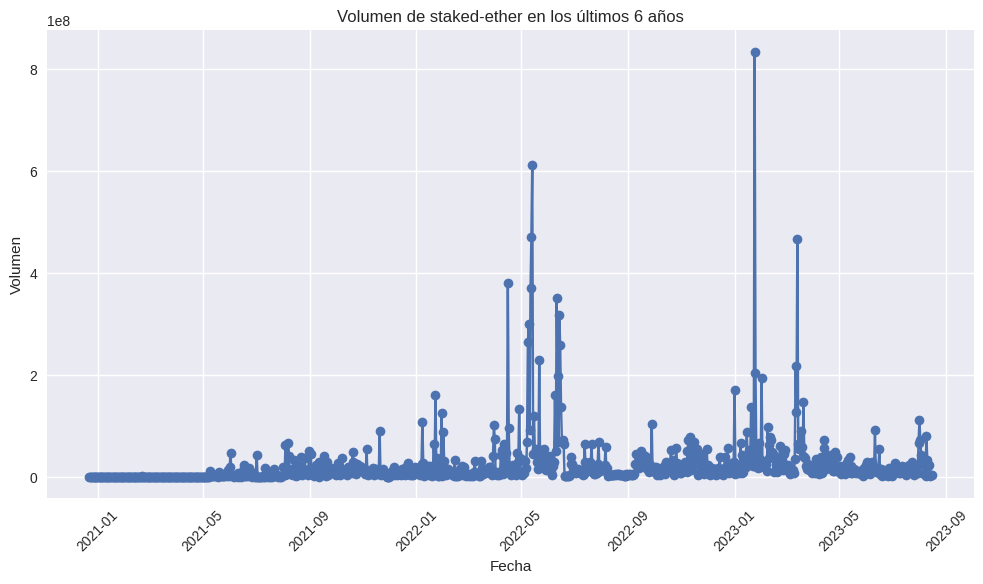

In [33]:
staked_ether_data = cg.get_coin_market_chart_range_by_id(id='staked-ether', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in staked_ether_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in staked_ether_data['prices']]

df_staked_ether = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_staked_ether['timestamp'], df_staked_ether['volume'], marker='o')
plt.title('Volumen de staked-ether en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se aprecia que los picos más altos de volumen se encuentran a mediados del año 2022 y a principios del año 2023

# Dogecoin

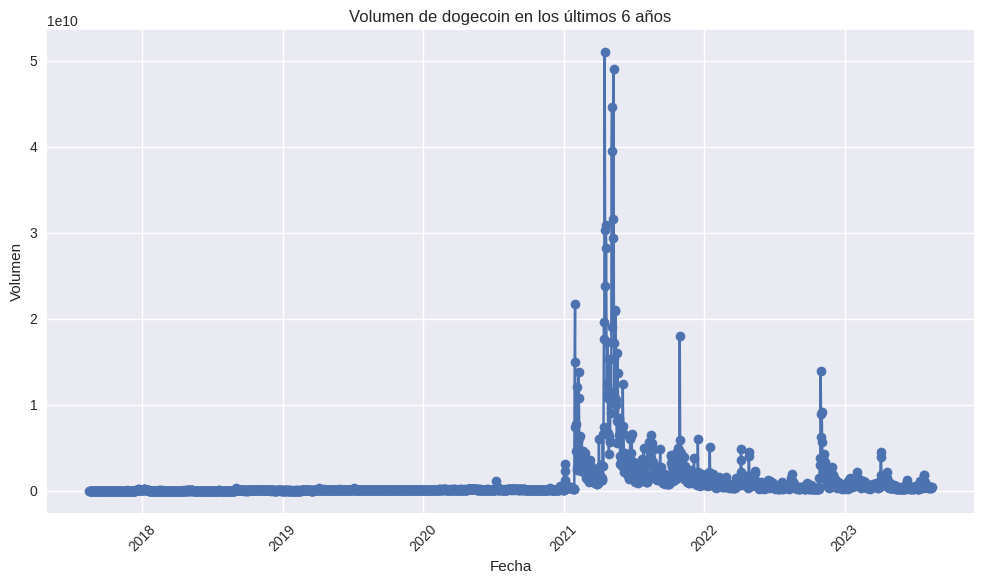

In [34]:
dogecoin_data = cg.get_coin_market_chart_range_by_id(id='dogecoin', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in dogecoin_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in dogecoin_data['prices']]

df_dogecoin = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_dogecoin['timestamp'], df_dogecoin['volume'], marker='o')
plt.title('Volumen de dogecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cardano

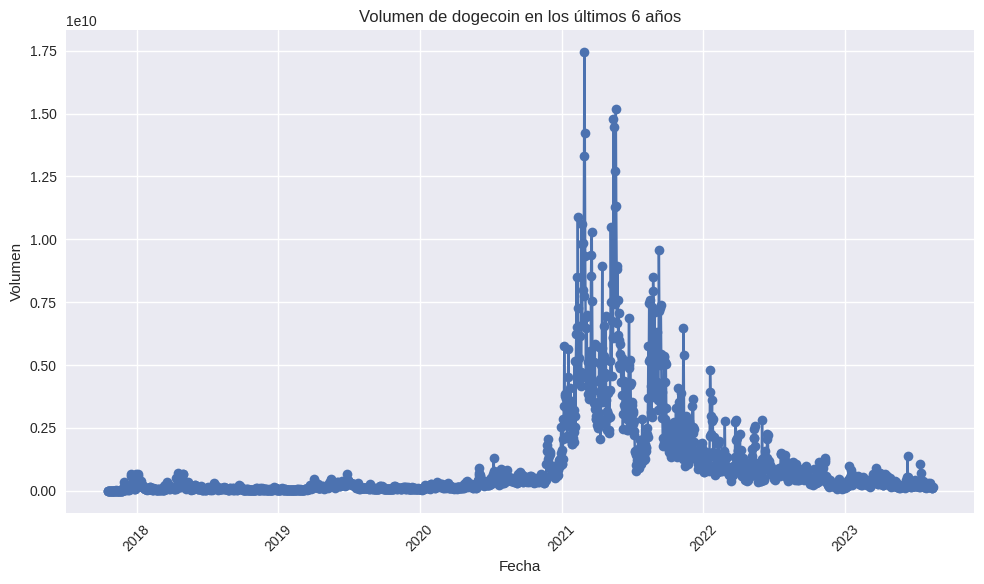

In [35]:
cardano_data = cg.get_coin_market_chart_range_by_id(id='cardano', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in cardano_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in cardano_data['prices']]

df_cardano = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_cardano['timestamp'], df_cardano['volume'], marker='o')
plt.title('Volumen de dogecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Solana

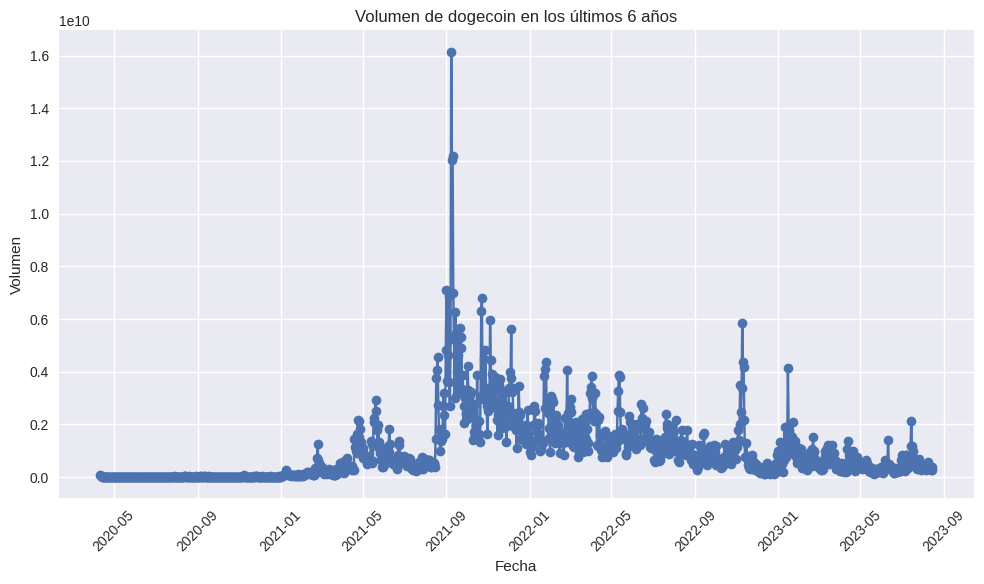

In [36]:
solana_data = cg.get_coin_market_chart_range_by_id(id='solana', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in solana_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in solana_data['prices']]

df_solana = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_solana['timestamp'], df_solana['volume'], marker='o')
plt.title('Volumen de dogecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se podría haber utilizado un mapa de calor, como se hizo con el dataset de precios, pero por complicaciones para unificar estos datos, se realizaron estos gráficos, sin embargo, a simple vista se podría decir que durante el año 2023, hasta la actualidad, todas las criptomonedas se mantuvieron relativamente uniformes respecto a su variación de volúmen.

#Ethereum

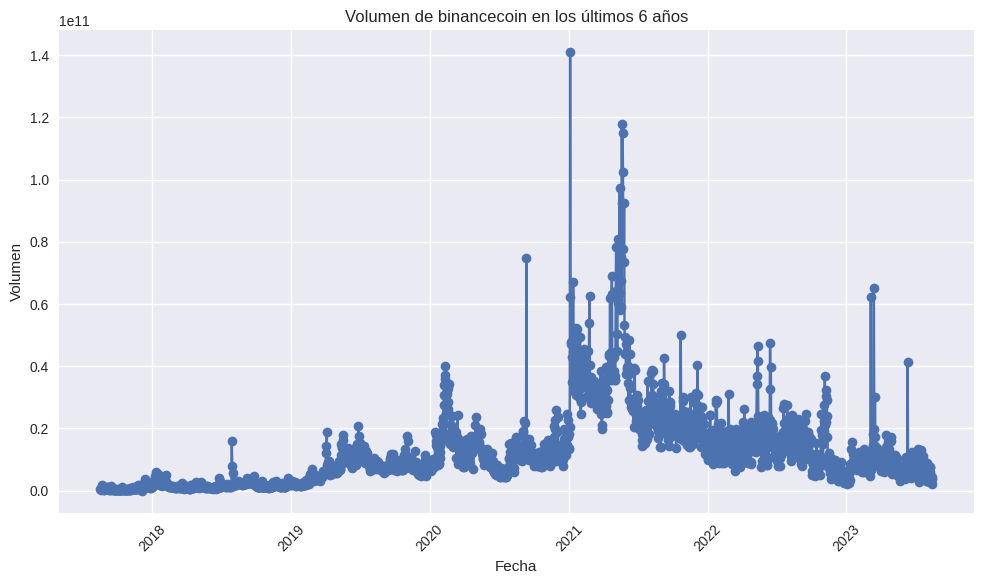

In [37]:
ethereum_data = cg.get_coin_market_chart_range_by_id(id='ethereum', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in ethereum_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in ethereum_data['prices']]

df_ethereum = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_ethereum['timestamp'], df_ethereum['volume'], marker='o')
plt.title('Volumen de binancecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bitcoin

Finalmente, se visualiza de forma individual el volúmen del bitcoin

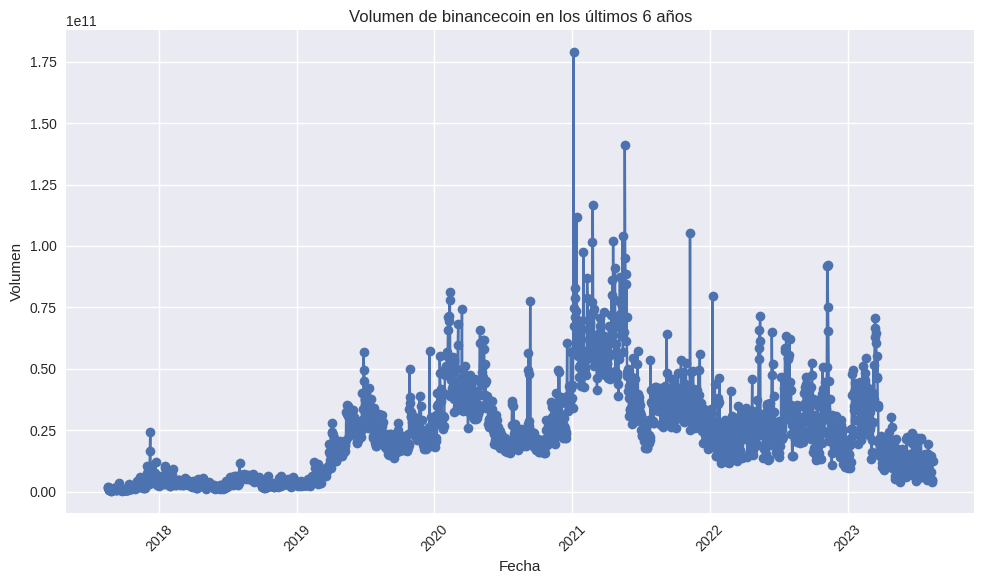

In [38]:
bitcoin_data = cg.get_coin_market_chart_range_by_id(id='bitcoin', vs_currency='usd', from_timestamp=desde, to_timestamp=hasta)

volumes = [entry[1] for entry in bitcoin_data['total_volumes']]
timestamps = [pd.to_datetime(entry[0], unit='ms') for entry in bitcoin_data['prices']]

df_bitcoin = pd.DataFrame({'timestamp': timestamps, 'volume': volumes})

plt.figure(figsize=(10, 6))
plt.plot(df_bitcoin['timestamp'], df_bitcoin['volume'], marker='o')
plt.title('Volumen de binancecoin en los últimos 6 años')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparación del volúmen de las crtiptomonedas en un gráfico unificado

In [39]:
df=[df_tether,df_binancecoin,df_ripple,df_usd_coin,df_staked_ether,df_dogecoin,df_cardano,df_solana,df_bitcoin, df_ethereum]

<ipython-input-40-84d506579be4>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') # se deja este estio porque si utilizo sns.set(style="whitegrid") se tapan los datos en el gráfico.


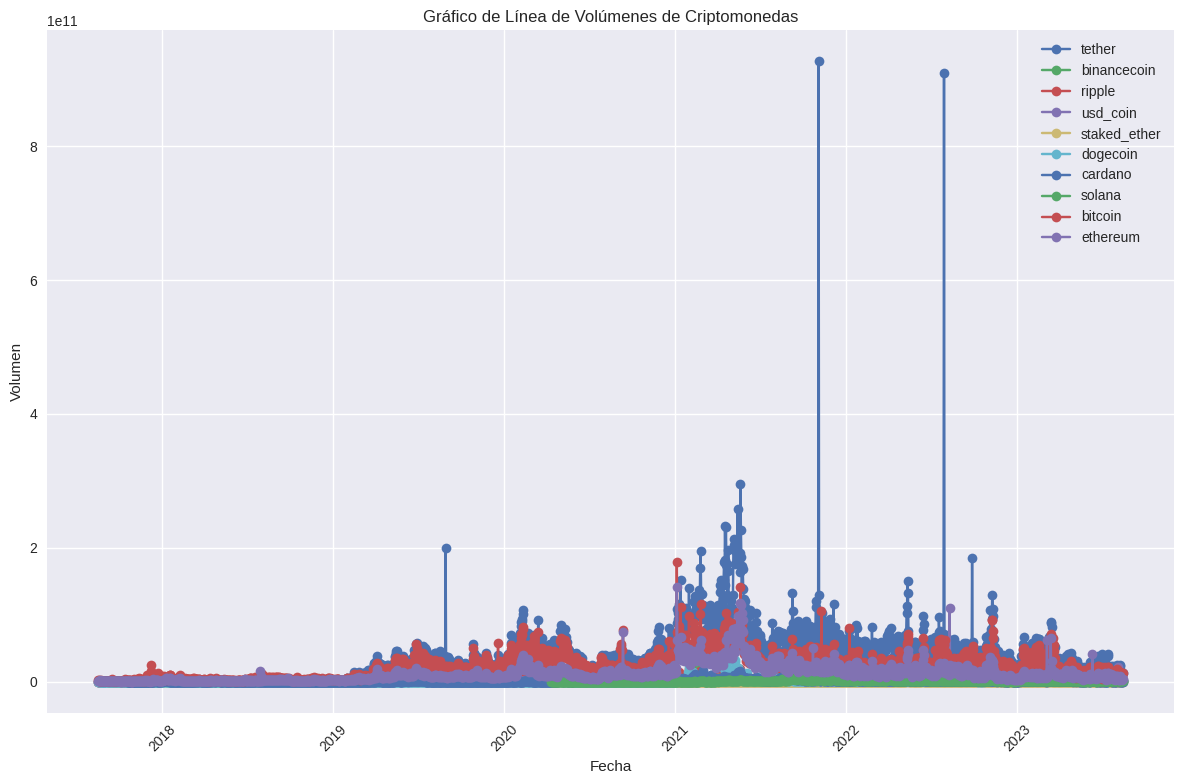

In [40]:

# se configura el estilo estético de Matplotlib
plt.style.use('seaborn') # se deja este estio porque si utilizo sns.set(style="whitegrid") se tapan los datos en el gráfico.

# se crea el gráfico de líneas para los volúmenes de todas las criptomonedas
plt.figure(figsize=(12, 8))

# Lista de nombres de criptomonedas
criptos = ["tether", "binancecoin", "ripple", "usd_coin", "staked_ether", "dogecoin", "cardano", "solana", "bitcoin", "ethereum"]

# Lista de dataframes de criptomonedas
df = [df_tether, df_binancecoin, df_ripple, df_usd_coin, df_staked_ether, df_dogecoin, df_cardano, df_solana, df_bitcoin, df_ethereum]

for sub_df, crypto_name in zip(df, criptos):
    plt.plot(sub_df['timestamp'], sub_df['volume'], marker='o', label=crypto_name)

plt.title('Gráfico de Línea de Volúmenes de Criptomonedas')
plt.xlabel('Fecha')
plt.ylabel('Volumen')
plt.xticks(rotation=45)
plt.legend()  # Agregar leyenda con los nombres de criptomonedas
plt.tight_layout()
plt.show()


Así como el mapa de calor del precio indicaba una alta correlación entre varias de las criptomonedas, parece suceder algo similar en términos del volúmen. Es interesante observar cómo el tiempo influye en la variación de los volúmenes, y de forma muy similar en todos. Sería aún más interesante complementar esto con las noticias que ocurrieron en esas fechas.

No se eliminarán outliers dado que se pretende, en este caso poder presentar la mayor cantidad de información posible para reducir el impacto del riesgo en la cartera de los inversores.

# En resumen
- Dado que existe un nivel muy alto de correlación entre las crpitomonedas, se podría pensar, en principio que todas tendrían el mismo comportamiento, sin embargo, se hará un posterior desarrollo de KPI's para poder indagar más en esta cuestión.
- No se eliminan outliers, dado que estos son importantes para intentar visibilzar posibles riesgos.
- Se hará uso de medias móviles para determinar aspectos más generales, y porque estas son más útiles para intervalos de tiempo grandes, sobre todo si la granularidad es diaria, como en este caso.
- Se aclara que estos graficos podrían cambiar significativamente si se cambian las temporalidades, pero ese estudio se hará en power bi.